In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import convolve2d

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# A bunch of utility functions

def show_array_images(images, title = ''):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    
    plt.suptitle(title)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
def imgshow(array_image):
    """ Show one array image as uint8 and remove axis labels """
    sqrtimg = int(np.ceil(np.sqrt(array_image.shape[0])))
    imshow_noax(array_image.reshape([sqrtimg,sqrtimg]), normalize=True)

def array_to_image(array):
    sqrtimg = int(np.ceil(np.sqrt(array.shape[0])))
    x = np.array(array.reshape([sqrtimg,sqrtimg]))
    return x
    
def image_to_array(image):
    l = image.shape[0]*image.shape[1]
    x = np.array(image.reshape([l]))
    return x

def center_square(array_image, square_h, square_w, pixel_value = 0.3):
    img = array_to_image(array_image)
    h, w = img.shape                     
    j = int(round((h - square_h)/2.))
    i = int(round((w - square_w)/2.))
    img[j:j+square_h, i:i+square_w] = pixel_value
    img = image_to_array(img)
    return img

def mask_images(array_images, masktype, *args):
    """ Retruns an array of image and masked image pairs """
    masked_images = []
    for array_image in array_images:
        if masktype == 'square':
            masked = center_square(array_image,*args)
        masked_images.append(array_image)
        masked_images.append(masked)
    return np.array(masked_images)

#utility functions for GANs

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

from itertools import izip

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return izip(a, a)

def rescale(a):
    return (a - np.min(a))/(np.max(a)-np.min(a))

def postporcess(mean_anomaly, ksize=3, threshold = 0.49):
    ker = 0.25*np.ones((ksize,ksize))
    a = convolve2d(array_to_image(mean_anomaly), ker, mode='same', boundary='symm')
    a = rescale(a)
    a = np.where(a >= threshold, 1,0)
    predicted_mask = image_to_array(a)
    return predicted_mask

def int_over_union(predicted, ground_truth):
    intersection = np.sum(np.multiply(predicted,ground_truth))
    union = predicted + ground_truth
    union = np.sum(np.clip(union,0,1))
    return intersection/union

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST', one_hot=False)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


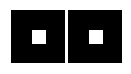

In [4]:
#Mask
mask = np.zeros(mnist.test.images[0].shape)
mask = center_square(mask,7,7)
rounded_mask = center_square(mask,7,7,1)
show = np.array([mask,rounded_mask])
show_array_images(show)

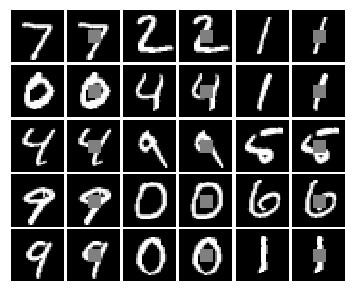

In [5]:
#Generating anomalies in images
masked_images = mask_images(mnist.test.images[0:15],'square',7,7, 0.5)
#masked_images = mask_images(mnist.test.next_batch(16),'square',7,7)
show_array_images(masked_images)

In [6]:
#Restore a model
tf.reset_default_graph()
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('../models/mnist_dcgan/mnist_dcgan.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('../models/mnist_dcgan/'))

INFO:tensorflow:Restoring parameters from ../models/mnist_dcgan/mnist_dcgan.ckpt


In [7]:
#Search inside ops
graph = tf.get_default_graph()
ops = graph.get_operations()

#searching with name and shape!

for op in ops:
    if 'discriminator/dense_layer/Maximum' in op.name and not('gradients' in op.name):
        print(op.name, op.inputs, op.outputs) 
op = graph.get_operation_by_name("sub")
print(op.name, op.outputs)


(u'discriminator/dense_layer/Maximum', <tensorflow.python.framework.ops._InputList object at 0x7ff58fdb4810>, [<tf.Tensor 'discriminator/dense_layer/Maximum:0' shape=(?, 1024) dtype=float32>])
(u'sub', [<tf.Tensor 'sub:0' shape=(?, 784) dtype=float32>])


In [8]:
#Find the nodes in the graph
graph = tf.get_default_graph()

#input of first operation we want to restore: generator = genertor input
#gi = graph.get_tensor_by_name("random_uniform/mul:0")
gi = graph.get_tensor_by_name("random_normal/mul:0")

#output of last operation we want to restore: discriminator = generator output
go = graph.get_tensor_by_name("generator/last_op_generator:0")
#go = graph.get_tensor_by_name("generator/Reshape_1:0")

#Generator loss
gl = graph.get_tensor_by_name("generator_loss:0")
#gl = graph.get_tensor_by_name("Mean_2:0")

#Discriminator feature layer output
dfl = graph.get_tensor_by_name('discriminator/dense_layer/Maximum:0')

#Discriminator input
di = graph.get_tensor_by_name('sub:0')

In [9]:
def features(image):
    features = sess.run(dfl,feed_dict={di: np.reshape(image, [-1,784])})
    return features

In [10]:
def generator(z,gi,go):
    G_sample = sess.run(go, feed_dict={gi: z})
    return G_sample

In [11]:
# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
#input dimensions
image_shape = go.shape[1:].as_list()

#Variables 
z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=-0.5))

# Generated images
G_sample = generator(z,gi,go)

#Features of image
x = masked_images[0]
f = features(x)
features_shape = f.shape

#Get solver
z_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5)

#Get loss
alpha = 0.9
beta = 1

with graph.as_default():
    images = tf.placeholder(tf.float32,image_shape, name='images') 
    xf = tf.placeholder(tf.float32,[1,1024], name='x_features') 
    #define loss
    #L2_loss = tf.nn.l2_loss(go-images)
    L2_loss = tf.norm(go-images)
    perceptual_loss = tf.nn.l2_loss(dfl-xf)
    z_loss = alpha*L2_loss + (1-alpha)*beta*perceptual_loss
    z_grads = tf.gradients(z_loss, gi) 

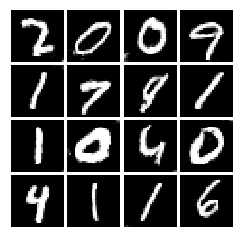

In [12]:
#Test sampling from generator
#z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=1))
z = sess.run(tf.random_normal([batch_size, noise_dim], mean=0, stddev=1))
sample_out = sess.run(go, feed_dict={gi: z})
show_array_images(sample_out[0:16])

In [13]:
def z_search(z, x, real_x, features, alpha,beta, nIter = 3000, v = 0, momentum = 0.9, adam = False, nesterov = False,
             lr = 0.001, print_every = 250, show_every = 500, multiple_images = False, decay_every  = 1000, 
             m = 0):
    
    loss_history = []
    show_history = []
    
    for i in range(nIter):
        out_vars = [L2_loss, perceptual_loss, z_loss, z_grads, go]
        in_dict = {gi: z, images: preprocess_img(x), xf: features, di: generator(z,gi,go) }

        loss1, loss2, loss, grad, imout = sess.run(out_vars, feed_dict=in_dict)
        

        
        #step decay
        if (i % decay_every == 0):
            lr = 0.5*lr
            
        if nesterov:    
            #Nesterov
            v_prev = np.copy(v)
            v = momentum*v - lr*grad[0]
            z += (-momentum * v_prev +
                       (1 + momentum) * v)
            z = np.clip(z, -1, 1)
        
        if adam:
            eps = 1e-8
            beta1 = 0.9
            beta2 = 0.999
            # Adam t is your iteration counter going from 1 to infinity
            dx = grad[0]
            t = i+1
            m = beta1*m + (1-beta1)*dx
            mt = m / (1-beta1**t)
            v = beta2*v + (1-beta2)*(dx**2)
            vt = v / (1-beta2**t)
            z += - lr * mt / (np.sqrt(vt) + eps)
        
        
        
        #Mean image
        mean = np.mean(imout, axis = 0)
        mean = deprocess_img(mean)
        
        if not(multiple_images):
            if (i % print_every == 0):
                print('Iteration {}: {}, l2: {}, pl:{}'.format(i, loss, alpha*loss1, (1-alpha)*beta*loss2))
        
            

            if (i % show_every == 0):
                show = np.array([real_x,x,imout[0],mean])
                show_array_images(show)
                plt.show()
        else:
            if (i % show_every == 0):
                show_history.append(np.array([real_x,x,imout[0],mean]))
            
        loss_history.append(loss)
        
    if not(multiple_images):     
        #final print
        print('Final images:')
        show = np.array([real_x,x,imout[0],mean])
        show_array_images(show)
        plt.show()
    
    return imout, loss_history, mean

Iteration 0: 195.925003052, l2: 184.951647949, pl:10.9733566284


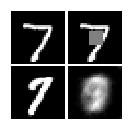

Iteration 250: 95.8350372314, l2: 84.4321769714, pl:11.4028594971
Iteration 500: 90.9016189575, l2: 78.9986549377, pl:11.9029670715


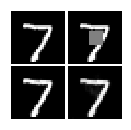

Iteration 750: 87.4537124634, l2: 74.8408927917, pl:12.6128234863
Iteration 1000: 86.2509613037, l2: 73.2216110229, pl:13.0293487549


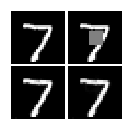

Iteration 1250: 86.0101318359, l2: 72.9175437927, pl:13.0925933838
Iteration 1500: 85.8380279541, l2: 72.5560661316, pl:13.2819671631


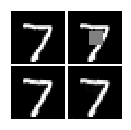

Iteration 1750: 86.6163864136, l2: 73.1304176331, pl:13.4859680176
Final images:


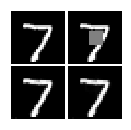

In [14]:
#Search in latent space
#z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=1))
z = sess.run(tf.random_normal([batch_size, noise_dim], mean=0, stddev=1))

real_x = masked_images[0]
x = masked_images[1]
fts = features(x)

imout,loss_history, mean = z_search(z, x,real_x,fts, alpha, beta, nIter=2000, show_every=500, momentum = 0.99,
                                    print_every=250, lr = 2, decay_every = 2000, adam = False, nesterov = True)

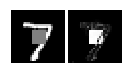

In [15]:
#show mean anomaly map for all candidates 
mean_anomaly = np.mean(np.abs(deprocess_img(imout)-x), axis=0)
show = np.array([x,mean_anomaly])
show_array_images(show)

In [16]:
#Postprocess
pmask = []
for img in imout:
     pmask.append(postporcess(np.abs(deprocess_img(img)-x), ksize=3, threshold=0.49))
predicted_mask = np.mean(pmask, axis = 0)
predicted_mask[predicted_mask>0.3] = 1
predicted_mask[predicted_mask<=0.3] = 0

#Quantify error between detected anomaly and real anomaly
err = int_over_union(predicted_mask,mean_anomaly) 

0.918367346939


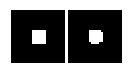

In [19]:
#Score of prediction vs gorund truth
print(int_over_union(rounded_mask, predicted_mask))
show = np.array([rounded_mask,predicted_mask])
show_array_images(show)

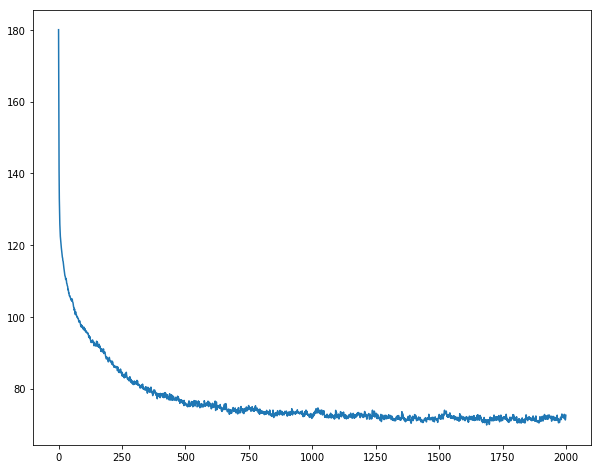

In [89]:
#Search loss curve
plt.plot(loss_history)
plt.show()

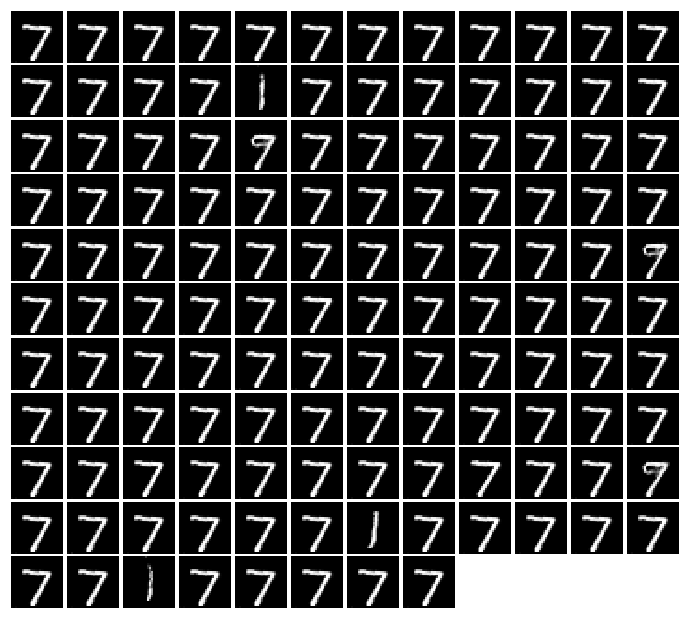

In [20]:
#show all candidates
show_array_images(imout)

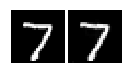

In [22]:
#show real image vs mean candidate
mean = np.mean(imout, axis = 0)
mean = deprocess_img(mean)

show = np.array([real_x,mean])
show_array_images(show)

(0.0, 0.0, 0.9999696, 1.0)


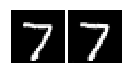

In [28]:
#Look for best candidate
losses = [int_over_union(array_to_image(deprocess_img(img)),array_to_image(real_x)) for img in imout]
idx = np.argsort(losses)

best = imout[idx[-1]]
best = deprocess_img(best)

#Sanity check
print(np.min(best), np.min(x), np.max(best), np.max(x))

#show best
show = np.array([real_x,best])
show_array_images(show)

L2: 292.584503174, pl: 3.72638845444, loss: 263.698699951


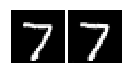

In [30]:
#Loss statistics of best image
img = best
beast = np.tile(img,(128,1))
fts = features(real_x)

out_vars = [L2_loss, perceptual_loss, z_loss]
in_dict = {go: beast, images: preprocess_img(x),xf: fts, di: beast}
loss1, loss2, loss = sess.run(out_vars, feed_dict=in_dict)
show = np.array([real_x,img])
show_array_images(show)
print('L2: {}, pl: {}, loss: {}'.format(loss1,loss2,loss))

In [37]:
#Compute perceptual losses for all images
perceptuals = []
for img in imout:
    img = deprocess_img(img)
    beast = np.tile(img,(128,1))
    fts = features(real_x)

    out_vars = [L2_loss, perceptual_loss, z_loss]
    in_dict = {go: beast, images: preprocess_img(x),xf: fts, di: beast}
    loss1, loss2, loss = sess.run(out_vars, feed_dict=in_dict) 
    perceptuals.append(loss2)

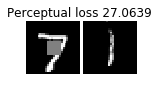

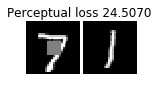

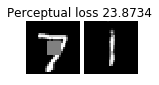

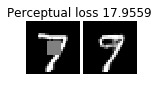

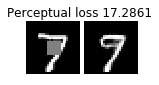

In [41]:
#Show worst perceptual images
idx = np.argsort(perceptuals)

for n in range(5):
    
    #best = imout[idx[n]]
    best = imout[idx[127-n]]
    #best = deprocess_img(best)

    loss = perceptuals[idx[127-n]]

    show = np.array([x,best])
    show_array_images(show, title = 'Perceptual loss {0:.4f}'.format(loss))

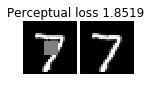

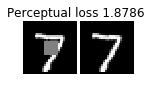

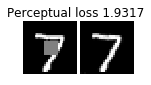

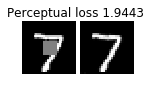

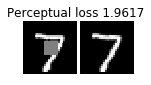

In [40]:
#Show best perceptual images
idx = np.argsort(perceptuals)
for n in range(5):
    
    best = imout[idx[n]]
    #best = imout[idx[127-n]]
    #best = deprocess_img(best)
    loss = perceptuals[idx[n]]
    #loss = perceptuals[idx[127-n]]
    
    show = np.array([x,best])
    show_array_images(show, title = 'Perceptual loss {0:.4f}'.format(loss))